In [108]:
import numpy as np
import matplotlib.pyplot as plt

def ellip_mask(x_center, y_center, a, b, num_pix, theta):
    
    nx = num_pix   # number of pixels in x-dir
    ny = num_pix   # number of pixels in y-dir

    # set up a coordinate system
    x = np.linspace(-num_pix / 2, num_pix / 2, nx)
    y = np.linspace(-num_pix / 2, num_pix / 2, ny)

    # Setup arrays which just list the x and y coordinates
    x_grid, y_grid = np.meshgrid(x, y)
    the = np.pi / 4
    xgrid = (x_grid - x_center) * np.cos(the) + (y_grid - y_center) * np.sin(the)
    ygrid = -(x_grid - x_center) * np.sin(the) + (y_grid - y_center) * np.cos(the) 

    # Calculate the ellipse values all at once
    ellipse = (xgrid) **2 / a**2 + (ygrid) **2 / b**2

    # Create an array of int32 zeros
    grey = np.ones((nx,ny), dtype=np.int32)

    # Put 1's where ellipse is less than 1.0
    # Note ellipse <1.0 produces a boolean array that then indexes grey
    grey[ellipse <= 1.0] = 0

    return grey

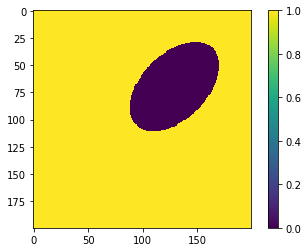

In [109]:
plt.imshow(ellip_mask(30, -30, 30, 50, 200, np.radians(45)), interpolation = 'none')
plt.colorbar()

In [ ]:
from astropy.io import fits

# Initialize data/priors
kernel = fits.getdata('/global/homes/s/shrihan/python_repo/hst_modeling/data/f140w00.fits').astype(np.float32)
fits_img = fits.getdata('/global/homes/s/shrihan/python_repo/hst_modeling/data/final_57_drz.fits')
observed_img = fits_img[1017:1137, 1170:1290]

bkg_est = fits_img[450:550, 1500:1600]
bg_rms = bkg_est.flatten().std()

prior = initialize_default_prior(theta_E = 2.8)
mask_img = ellip_mask(0, 0, a = 10, b = 10, num_pix = 120, theta = jnp.radians(45))

# Initialize 
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=120, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], 
                           [sersic.SersicEllipse(use_lstsq=False)])

#observed_img = np.pad(np.load('/global/homes/s/shrihan/python_repo/gigalens/src/gigalens/assets/demo.npy'), ((30,30), (30,30)), mode=random_pad)
# observed_img[23:37, 23:40] = 0

lens_sim = LensSimulator(phys_model, sim_config, bs=1)
prob_model = ForwardProbModel(prior, observed_img, background_rms=bg_rms, exp_time=1200, mask_image = mask_img)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)